In [1]:
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
import xarray as xr

import h5py
import cartopy.crs as ccrs
    
from mydedalustools import *    

%load_ext autoreload
%autoreload 2

SNAPSHOTS_DIR = "/pscratch/sd/q/qnicolas/stationarywave_snapshots/"

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1


/global/common/software/m3310/conda/dedalus3/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


This notebook presents a test of a 12-level sigma model: Gill pattern in the tropics.

In [2]:
# Simulation units
meter = 1 / 6.37122e6
hour = 1
second = hour / 3600
day = hour*24
Kelvin = 1
kilogram=1.
Pascal = kilogram / meter / second ** 2

# Earth parameters
R0 = 6.4e6*meter
Omega = 2*np.pi/86400 / second
g = 9.81 * meter/second**2
p0 = 1e5 * Pascal

# Gill pattern

In [3]:
snapshot_id = 'stationarywave_12level_T32_gill'
gill = open_h5s(snapshot_id,('s1',),SNAPSHOTS_DIR=SNAPSHOTS_DIR)
gill = concat_levels(gill ,12)


## Heating pattern

Text(0.5, 1.0, 'Heating at mid levels (K/day)')

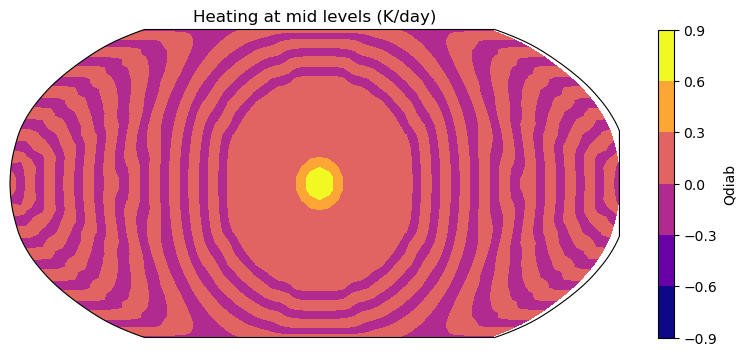

In [4]:
# Perturbation vorticity in rhs run
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(gill.Qdiab.isel(t=0,sigma=5)/(Kelvin/day)).transpose().plot.contourf(ax=ax,transform=ccrs.PlateCarree(),cmap=plt.cm.plasma)
plt.title('Heating at mid levels (K/day)')

In [5]:
qdiab = gill.Qdiab
def plot_heating(ax):
    (qdiab.isel(t=0,sigma=5)/(Kelvin/day)).plot.contour(ax=ax,levels=[0.4],colors='k',transform=ccrs.PlateCarree())

## Response

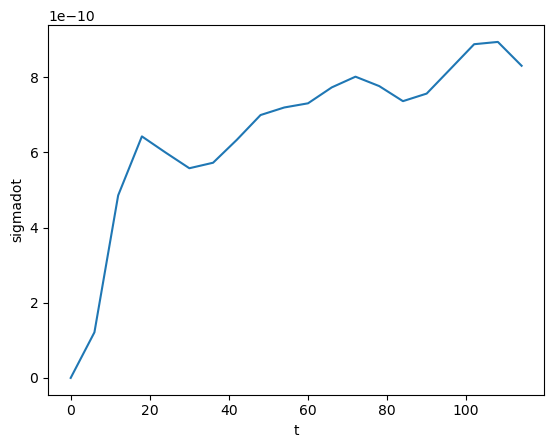

In [6]:
# CONVERGENCE
(gill.sigmadot**2).mean(('longitude','latitude','sigma_stag')).plot()


In [7]:
gill_mean = gill.sel(t=slice(100,None)).mean('t').transpose('','latitude','longitude','sigma','sigma_stag')

Text(0.5, 1.0, 'Perturbation vorticity at sigma=0.25 (s^-1)')

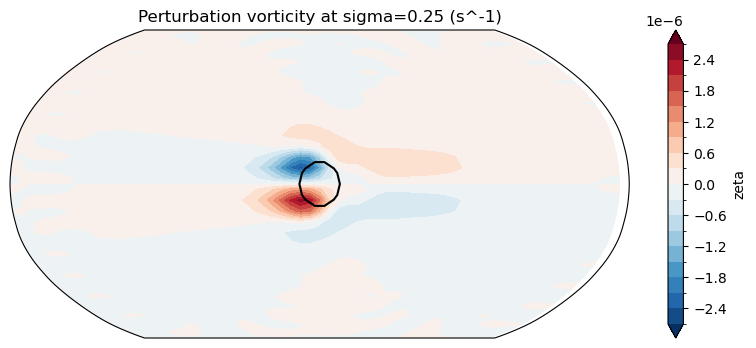

In [8]:
# Perturbation vorticity
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(gill_mean.zeta.sel(sigma=0.25,method='nearest') * second).plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())
plot_heating(ax)
plt.title('Perturbation vorticity at sigma=0.25 (s^-1)')

Text(0.5, 1.0, 'Perturbation surface pressure and wind at sigma=0.75 ')

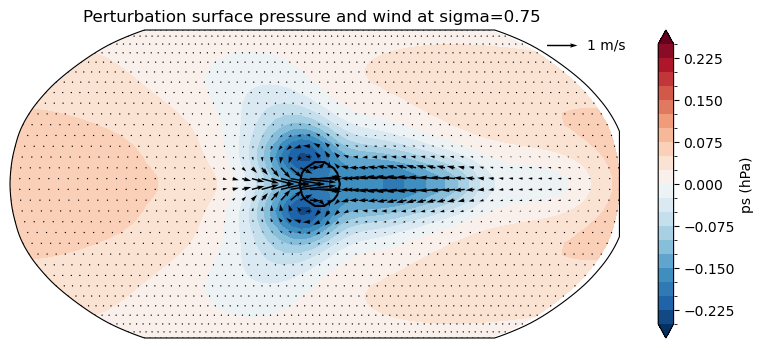

In [20]:
# Perturbation pressure (~p0 * lnps)
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(1e3*gill_mean.lnps).plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label': 'ps (hPa)'})

plot_heating(ax)

u= (gill_mean.u[0].sel(sigma=0.75,method='nearest'))/(meter/second)
v=-(gill_mean.u[1].sel(sigma=0.75,method='nearest'))/(meter/second)
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
n=1;m=n
Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m],color="k",scale=20,transform=ccrs.PlateCarree())
ax.quiverkey(Q, 0.93,0.95, 1., label='1 m/s', labelpos='E', coordinates='axes',color='k')

plt.title('Perturbation surface pressure and wind at sigma=0.75 ')

Text(0.5, 1.0, 'Perturbation pressure velocity (not sigma_dot) at sigma=0.5 ')

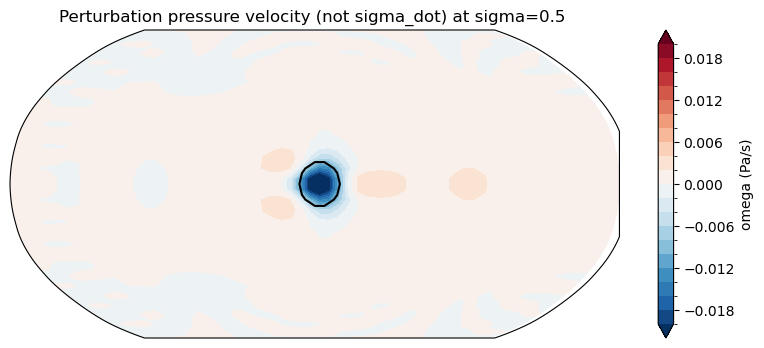

In [11]:
# Perturbation pressure (~p0 * lnps)
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})

(gill_mean.omega.sel(sigma_stag=0.5,method='nearest')/(Pascal/second)).plot.contourf(ax=ax,levels=np.linspace(-1,1,21)/5e1,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label': 'omega (Pa/s)'})

plot_heating(ax)

plt.title('Perturbation pressure velocity (not sigma_dot) at sigma=0.5 ')

## Comparing the LHS formulation

In [12]:
snapshot_id = 'stationarywave_12level_T32_gill_lhs'
gill_lhs = open_h5s(snapshot_id,('s1',),SNAPSHOTS_DIR=SNAPSHOTS_DIR)
gill_lhs = concat_levels(gill_lhs ,12)
gill_lhs_mean = gill_lhs.sel(t=slice(100,None)).mean('t').transpose('','latitude','longitude','sigma','sigma_stag')


Text(0.5, 1.0, 'Perturbation surface pressure and wind at sigma=0.75 ')

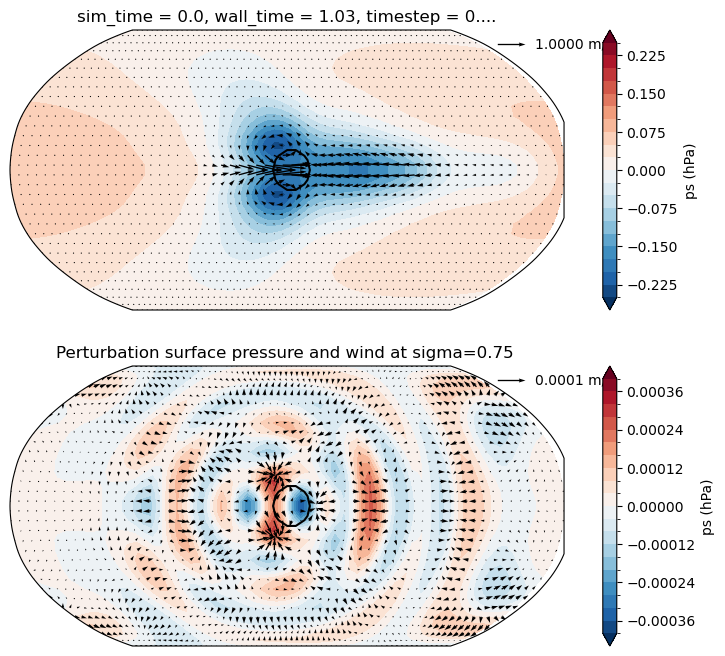

In [28]:
# Perturbation pressure (~p0 * lnps)
_,axs=plt.subplots(2,1,figsize=(10,8),subplot_kw={'projection':ccrs.Robinson()})

for ax,sim,sc in zip(axs,(gill_mean,gill_lhs_mean-gill_mean),(20,2e-3)):
    (1e3*sim.lnps).plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label': 'ps (hPa)'})
    
    u= (sim.u[0].sel(sigma=0.75,method='nearest'))/(meter/second)
    v=-(sim.u[1].sel(sigma=0.75,method='nearest'))/(meter/second)
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=1;m=n
    Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m],color="k",scale=sc,transform=ccrs.PlateCarree())
    ax.quiverkey(Q, 0.93,0.95, sc/20, label='%.4f m/s'%(sc/20), labelpos='E', coordinates='axes',color='k')

    plot_heating(ax)

plt.title('Perturbation surface pressure and wind at sigma=0.75 ')